In [2]:
from sys import path
path.append("../")

# Introduction 

In this notebook, I analyse the correlation among the left and right signals, for both PPG and EDA signals (the ACC does not make sense), with reference to the different **events** in the experiment. Indeed, literature has shown how different brain activations can lead to different signals in EDA, especially with reference to the side. The same is not true for PPG though.

The analysis of correlation for the whole timeseries has already proven how the PPG is, as expected, highly correlated from left to right, while the EDA has a very low correlation.
Indeed, for the latter, even if the value is statistically different from 0, it can be stated that there is some initial suggestion that the signals follow slightly different patterns on the left and on the right; it should be kept in mind that we do not except to hae 0 correlation, since the signals in same cases are expected to behave in a similar manner.

# Preparation

In [3]:
from pandas import read_parquet, IndexSlice, concat, DataFrame, Series
from src.utils import slice_user_over_experiment_time
from src.utils.correlation import calculate_correlation_coefficients
from src.utils.plots import bland_altman_plot
from scipy.stats import pearsonr, spearmanr, kendalltau
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
from time import time
from tqdm.notebook import tqdm
from seaborn import heatmap
from matplotlib.pyplot import figure, savefig, show, title
from numpy import array, asarray, ndarray, mean
from copy import deepcopy

def change_orientation(x: DataFrame) -> DataFrame:
    users = x.index.get_level_values(1).unique()
    event = x.index.get_level_values(0).unique()
    x = array(x)
    x = DataFrame(x, index=users, columns=event).T
    return x


def calculate_mean_difference(x: DataFrame, use_abs: bool = False) -> ndarray:
    data1: Series = x.loc[:, "left"]
    data2: Series = x.loc[:, "right"]
    data1: ndarray = asarray(data1)
    data2: ndarray = asarray(data2)
    if use_abs:
        diff: ndarray = abs(data1 - data2)  # Absolute Difference between data1 and data2
    else:
        diff: ndarray = data1 - data2  # Difference between data1 and data2
    md = mean(diff)
    return md

In [4]:
experimento_info = read_parquet("../../ContinuousLaugh/data.nosync/all_experimento_info_corrected.parquet")

In [5]:
experimento_info.loc[IndexSlice['s037', :], :]

start                 end  duration
s037 baseline_1      2018-06-14 15:15:24 2018-06-14 15:16:24        60
     baby            2018-06-14 15:16:26 2018-06-14 15:17:15        49
     people_car      2018-06-14 15:17:15 2018-06-14 15:17:22         7
     stand_up_comedy 2018-06-14 15:17:22 2018-06-14 15:19:53       151
     news            2018-06-14 15:19:54 2018-06-14 15:20:10        16
     himym           2018-06-14 15:20:11 2018-06-14 15:21:43        92
     cat             2018-06-14 15:21:44 2018-06-14 15:22:24        40
     penguins        2018-06-14 15:22:24 2018-06-14 15:23:23        59
     man             2018-06-14 15:23:23 2018-06-14 15:24:08        45
     bbt             2018-06-14 15:24:09 2018-06-14 15:25:49       100
     people_falling  2018-06-14 15:25:50 2018-06-14 15:26:39        49
     baseline_2      2018-06-14 15:26:39 2018-06-14 15:27:09        30
     fake            2018-06-14 15:27:10 2018-06-14 15:27:40        30
     baseline_3      2018-06-14 15:27:41 2018-06-14 15:28:11        30
     clapping_hands  2018-06-14 15:28:11 2018-06-14 15:28:41        30
     baseline_4      2018-06-14 15:28:42 2018-06-14 15:29:12        30
     cognitive_load  2018-06-14 15:29:12 2018-06-14 15:29:55        43
     baseline_5      2018-06-14 15:29:56 2018-06-14 15:30:56        60
     experiment      2018-06-14 15:15:22 2018-06-14 15:30:57       935

In [6]:
sessions_groupings: dict[str, list[str]] = {
    "baseline": ["baseline_1", "baseline_2", "baseline_3", "baseline_4", "baseline_5"],
    "cognitive_load": ["cognitive_load"],
    "fake_laughter": ["fake"],
    "clapping_hands": ["clapping_hands"],
    "funny_videos": [
        "baby",
        "people_car",
        "stand_up_comedy",
        "himym",
        "cat",
        "penguins",
        "man",
        "bbt",
        "people_falling",
    ],
}


From this user example, we can see the multiple events that were performed during a single experiment. In order to analyse the correlation between the left and right signals, some events shall be aggregated, in order to the following "macro-events":
1. Baseline: nothing here is happening and the user is just asked to sit still and move as little as possible. Comprised of all baseline event (from 1 to 5). We do not expect to see large differences in sides for the EDA here.
2. Cognitive load, where the user is shown something to stimulate the brain. We expect here to see some differences between the sides.
3. Clapping hands
4. Fake laughter
5. Video-watching, which comprises all of the moments a users was shown videos; in this case, some laughter episode could be part of them, so we should be careful
6. Laugher Episodes, manually annotated in the dataset.

Whichever of the left or right side has a larger activation, we hope to find similar results across all of the users; this will be analyzed using regression coefficient from the Bland-Altman plot.

### Adding Laugher Episodes

In [7]:
from pandas import read_excel, MultiIndex, to_datetime
from numpy import nan as NaN

INTENSITIES_MAPPING: dict[str, float] = {"low": 0, "medium": 1, "high": 2}


path_to_laughter_info: str = "/Users/leonardoalchieri/Datasets/USILaughs/laughter_episodes_annotations.xlsx"
laughter_info_data = read_excel(path_to_laughter_info, header=0, index_col=0)
laughter_info_data.index = MultiIndex.from_tuples(
        [tuple(idx.split("_")) for idx in laughter_info_data.index]
    )
laughter_info_data = laughter_info_data.sort_index()
laughter_info_data["intensity"] = (
        laughter_info_data["intensity"]
        .apply(lambda x: INTENSITIES_MAPPING.get(x, NaN))
        .astype(float)
    )

laughter_info_data = laughter_info_data[laughter_info_data["intensity"] > 0]
laughter_info_data[["start", "end"]] = laughter_info_data[["start", "end"]].apply(
        to_datetime
    )

In [8]:
sessions_groupings_w_laugh = deepcopy(sessions_groupings)
sessions_groupings_w_laugh['laugther episodes'] = list(laughter_info_data.index.get_level_values(1).unique())

In [9]:
# Join the laughter info with the experimento info
experimento_info_w_laugh = concat([laughter_info_data.iloc[:,:3], experimento_info], axis=0).sort_index()

### Group Durations

In [10]:
experimento_info_w_laugh.loc[IndexSlice['s037', :], :]

start                 end  duration
s037 baby            2018-06-14 15:16:26 2018-06-14 15:17:15        49
     baseline_1      2018-06-14 15:15:24 2018-06-14 15:16:24        60
     baseline_2      2018-06-14 15:26:39 2018-06-14 15:27:09        30
     baseline_3      2018-06-14 15:27:41 2018-06-14 15:28:11        30
     baseline_4      2018-06-14 15:28:42 2018-06-14 15:29:12        30
     baseline_5      2018-06-14 15:29:56 2018-06-14 15:30:56        60
     bbt             2018-06-14 15:24:09 2018-06-14 15:25:49       100
     cat             2018-06-14 15:21:44 2018-06-14 15:22:24        40
     clapping_hands  2018-06-14 15:28:11 2018-06-14 15:28:41        30
     cognitive_load  2018-06-14 15:29:12 2018-06-14 15:29:55        43
     experiment      2018-06-14 15:15:22 2018-06-14 15:30:57       935
     f0t0e3          2018-06-14 15:22:39 2018-06-14 15:22:42         3
     f0t0e5          2018-06-14 15:22:58 2018-06-14 15:23:02         4
     fake            2018-06-14 15:27:10 2018-06-14 15:27:40        30
     himym           2018-06-14 15:20:11 2018-06-14 15:21:43        92
     man             2018-06-14 15:23:23 2018-06-14 15:24:08        45
     news            2018-06-14 15:19:54 2018-06-14 15:20:10        16
     penguins        2018-06-14 15:22:24 2018-06-14 15:23:23        59
     people_car      2018-06-14 15:17:15 2018-06-14 15:17:22         7
     people_falling  2018-06-14 15:25:50 2018-06-14 15:26:39        49
     stand_up_comedy 2018-06-14 15:17:22 2018-06-14 15:19:53       151

In [11]:
from pandas import Series
from IPython.display import display


def get_group_durations(x: DataFrame) -> DataFrame:
    return_df = Series(index=list(sessions_groupings.keys()), dtype="float")
    for group in sessions_groupings.keys():
        return_df[group] = sum(
            x.loc[IndexSlice[:, event], "duration"][0]
            for event in sessions_groupings[group]
            if event in x.index.get_level_values(1)
        )
    return return_df


events_durations = experimento_info_w_laugh.groupby(level=0, axis=0).apply(get_group_durations)
# events_durations = events_durations.iloc[0, :]
events_durations.name = "event durations"
events_durations.mean()


baseline          210.0
cognitive_load     43.0
fake_laughter      30.0
clapping_hands     30.0
funny_videos      592.0
dtype: float64

# EDA-mixed

In [11]:
# Load Data
all_data = read_parquet("../../ContinuousLaugh/data.nosync/all_data_minmax_norm.parquet")
# NOTE: I consider only the datapoints where I have both the left and right signals
eda_data = all_data.loc[:, IndexSlice[:, 'EDA_filt_stand']].dropna(how='any')
eda_data = eda_data.groupby(level=0, axis=0, group_keys=False).apply(
    slice_user_over_experiment_time, experimento_info=experimento_info, slicing_col='experiment'
)
eda_data.columns = eda_data.columns.droplevel(1)

/Users/leonardoalchieri/Desktop/GIT/LateralizationPhysiologicalWearables/notebooks/../src/utils/__init__.py:202: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return user_data.loc[IndexSlice[:, start:end], :]
/Users/leonardoalchieri/Desktop/GIT/LateralizationPhysiologicalWearables/notebooks/../src/utils/__init__.py:202: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return user_data.loc[IndexSlice[:, start:end], :]
/Users/leonardoalchieri/Desktop/GIT/LateralizationPhysiologicalWearables/notebooks/../src/utils/__init__.py:202: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return us

In [12]:
different_groupings_eda_data_w_laugh: dict[str, DataFrame] = concat(
    [
        concat(
            [
                eda_data.groupby(level=0, axis=0, group_keys=False).apply(
                    slice_user_over_experiment_time,
                    experimento_info=experimento_info_w_laugh,
                    slicing_col=session,
                )
                for session in session_group
            ]
        )
        for session_group in sessions_groupings_w_laugh.values()
    ],
    keys=[group_name for group_name in sessions_groupings_w_laugh.keys()],
    names=["grouping"],
)


/Users/leonardoalchieri/Desktop/GIT/LateralizationPhysiologicalWearables/notebooks/../src/utils/__init__.py:202: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return user_data.loc[IndexSlice[:, start:end], :]
/Users/leonardoalchieri/Desktop/GIT/LateralizationPhysiologicalWearables/notebooks/../src/utils/__init__.py:202: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return user_data.loc[IndexSlice[:, start:end], :]
/Users/leonardoalchieri/Desktop/GIT/LateralizationPhysiologicalWearables/notebooks/../src/utils/__init__.py:202: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return us

In [13]:
from src.utils.dcca import detrended_correlation
from numpy import nan
from joblib import Parallel, delayed


def calculate_detrended_cross_correlation(
    df: DataFrame, time_scale: int = 20, max_time_lag: int = 200
):
    x = df.loc[:, "left"].values
    y = df.loc[:, "right"].values
    
    try:
        dcca = Parallel(n_jobs=-1)(
            delayed(detrended_correlation)(
                x=x, y=y, time_scale=time_scale, time_lag=time_lag
            )
            for time_lag in range(max_time_lag)
        )
    except ValueError:
        return nan
    return max(dcca) if len(dcca) > 0 else nan



In [37]:
even_correlations = different_groupings_eda_data_w_laugh.groupby(axis=0, level=[0,1]).apply(
    calculate_detrended_cross_correlation, time_scale=20, max_time_lag=int(32*0.5)
)

/Users/leonardoalchieri/Desktop/GIT/LateralizationPhysiologicalWearables/notebooks/../src/utils/dcca/__init__.py:115: RuntimeWarning: overflow encountered in multiply
  numerator = sum(x_box_residuals * y_box_residuals, axis=1)
/Users/leonardoalchieri/Desktop/GIT/LateralizationPhysiologicalWearables/notebooks/../src/utils/dcca/__init__.py:115: RuntimeWarning: overflow encountered in multiply
  numerator = sum(x_box_residuals * y_box_residuals, axis=1)
/Users/leonardoalchieri/Desktop/GIT/LateralizationPhysiologicalWearables/notebooks/../src/utils/dcca/__init__.py:115: RuntimeWarning: overflow encountered in multiply
  numerator = sum(x_box_residuals * y_box_residuals, axis=1)
/Users/leonardoalchieri/Desktop/GIT/LateralizationPhysiologicalWearables/notebooks/../src/utils/dcca/__init__.py:115: RuntimeWarning: overflow encountered in multiply
  numerator = sum(x_box_residuals * y_box_residuals, axis=1)
/Users/leonardoalchieri/Desktop/GIT/LateralizationPhysiologicalWearables/notebooks/../sr

In [38]:
# different_groupings_eda_data_w_laugh.loc[IndexSlice[:, 's071'], :].sort_index(level=2)

In [39]:
# different_groupings_eda_data_w_laugh.loc[IndexSlice[:, 's071'], :].sort_index(level=2).plot()

In [40]:
# import numpy as np
# x = different_groupings_eda_data_w_laugh.loc[IndexSlice['cognitive_load', 's071'], 'left'].values.astype(np.longdouble)
# y = different_groupings_eda_data_w_laugh.loc[IndexSlice['cognitive_load', 's071'], 'right'].values.astype(np.longdouble)

In [41]:
# from src.utils.dcca import detrended_correlation

# detrended_correlation(x=x, y=y, time_scale=20, time_lag=32*2) 

In [42]:
# from src.utils.dcca.old import detrended_correlation
# x = different_groupings_eda_data_w_laugh.loc[IndexSlice['cognitive_load', 's071'], 'left'].values
# y = different_groupings_eda_data_w_laugh.loc[IndexSlice['cognitive_load', 's071'], 'right'].values
# detrended_correlation(x=x, y=y, time_scale=20, time_lag=32*2) 

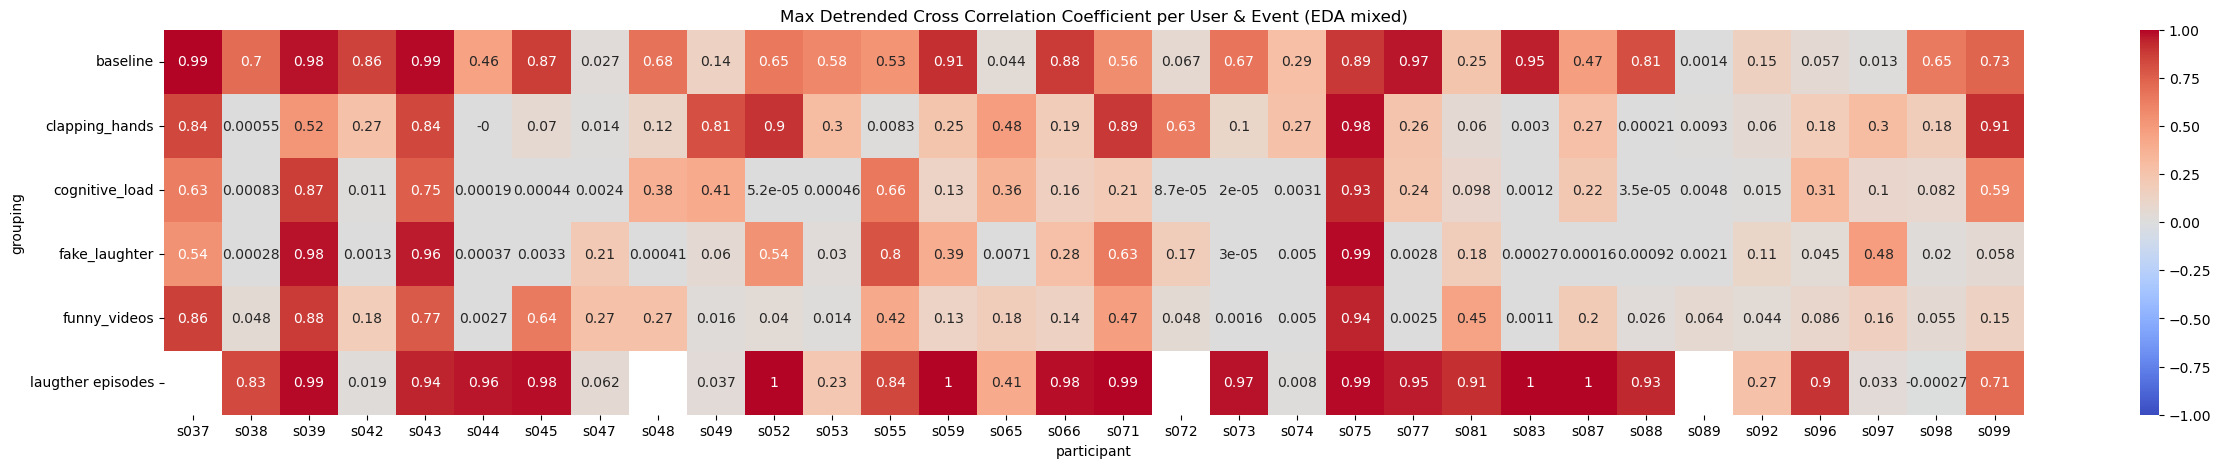

In [44]:
df_to_save = even_correlations.unstack(level=1)

figure(figsize=(30, 5))
heatmap(df_to_save, 
        xticklabels=df_to_save.columns,
        vmax=1, vmin=-1, center=0,
        cmap='coolwarm',
        yticklabels=df_to_save.index, annot=True)
title("Max Detrended Cross Correlation Coefficient per User & Event (EDA mixed)")
# savefig('../visualizations/event_correlation_eda_mixed_evenxuser.pdf', bbox_inches='tight')

show()

In [23]:
even_correlations = different_groupings_eda_data_w_laugh.groupby(axis=0, level=1).apply(
    calculate_detrended_cross_correlation, time_scale=20, max_time_lag=32*3
)

/Users/leonardoalchieri/Desktop/GIT/LateralizationPhysiologicalWearables/notebooks/../src/utils/dcca/__init__.py:115: RuntimeWarning: overflow encountered in multiply
  numerator = sum(x_box_residuals * y_box_residuals, axis=1)
/Users/leonardoalchieri/Desktop/GIT/LateralizationPhysiologicalWearables/notebooks/../src/utils/dcca/__init__.py:115: RuntimeWarning: overflow encountered in multiply
  numerator = sum(x_box_residuals * y_box_residuals, axis=1)
/Users/leonardoalchieri/Desktop/GIT/LateralizationPhysiologicalWearables/notebooks/../src/utils/dcca/__init__.py:115: RuntimeWarning: overflow encountered in multiply
  numerator = sum(x_box_residuals * y_box_residuals, axis=1)
/Users/leonardoalchieri/Desktop/GIT/LateralizationPhysiologicalWearables/notebooks/../src/utils/dcca/__init__.py:115: RuntimeWarning: overflow encountered in multiply
  numerator = sum(x_box_residuals * y_box_residuals, axis=1)
/Users/leonardoalchieri/Desktop/GIT/LateralizationPhysiologicalWearables/notebooks/../sr

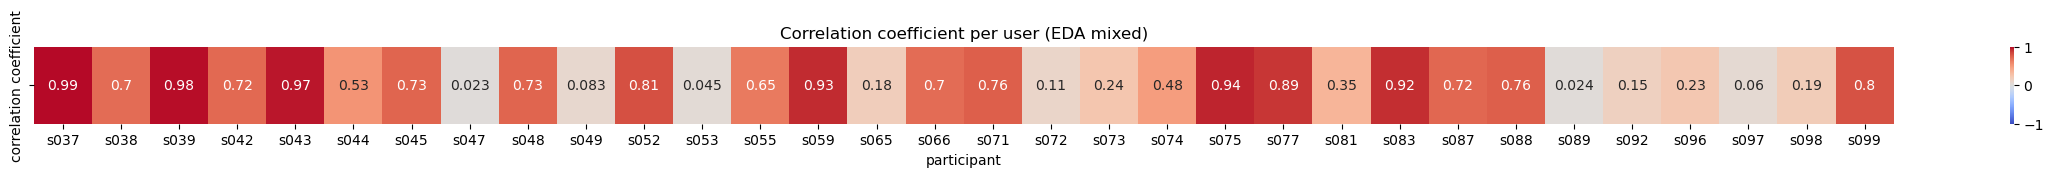

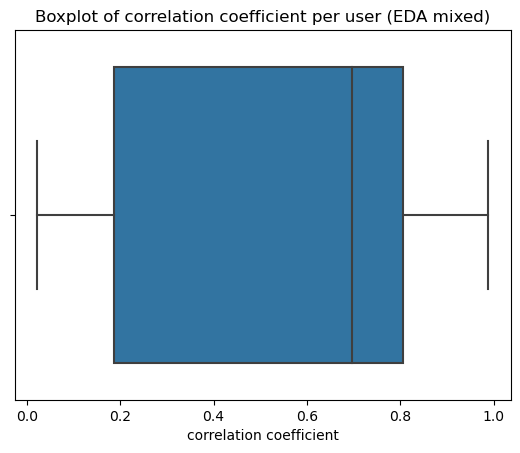

In [24]:
df_to_save = DataFrame(even_correlations, columns=['correlation coefficient']).T

figure(figsize=(30, 1))
heatmap(df_to_save, 
        xticklabels=df_to_save.columns,
        vmax=1, vmin=-1, center=0,
        cmap='coolwarm',
        yticklabels=df_to_save.index, annot=True)
title('Correlation coefficient per user (EDA mixed)')
savefig("../visualizations/user_correlation_eda.pdf", bbox_inches='tight')
show()
from seaborn import boxplot


boxplot(x = df_to_save.iloc[0,:])
title('Boxplot of correlation coefficient per user (EDA mixed)')
# savefig("../visualizations/user_boxplot_eda.pdf", bbox_inches='tight')
show()

/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_15171/1879273747.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_to_save = df_to_save.iloc[:,0].groupby(level=0, group_keys=False).apply(change_orientation)


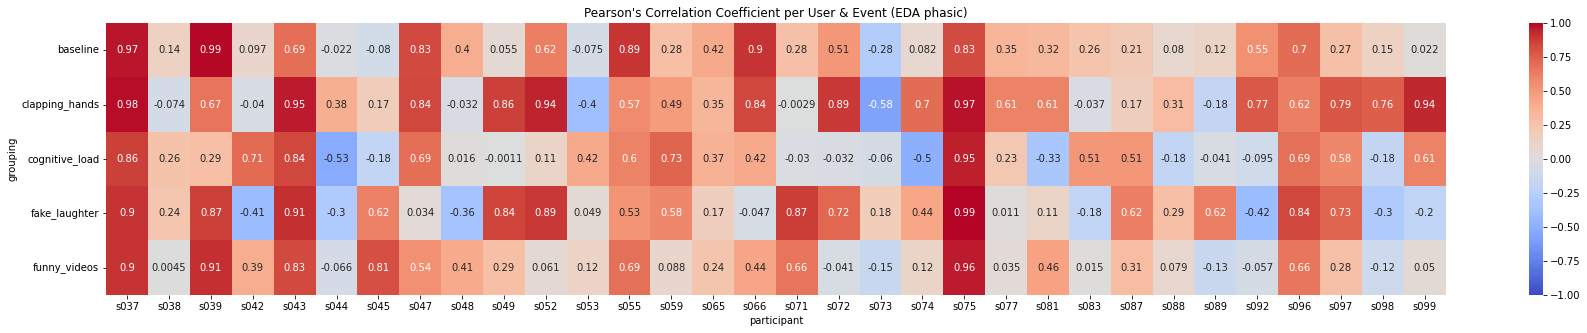

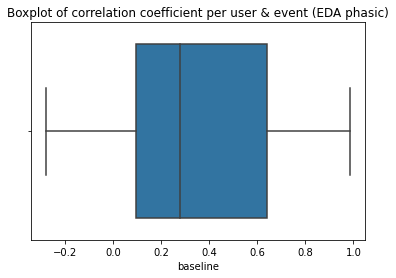

In [69]:

even_correlations = different_groupings_eda_data_w_laugh.groupby(axis=0, level=[0,1]).apply(
    calculate_correlation_coefficients
)
df_to_save = even_correlations.loc[:, IndexSlice[:,'value']]

df_to_save = df_to_save.iloc[:,0].groupby(level=0, group_keys=False).apply(change_orientation)

figure(figsize=(30, 5))
heatmap(df_to_save, 
        xticklabels=df_to_save.columns,
        vmax=1, vmin=-1, center=0,
        cmap='coolwarm',
        yticklabels=df_to_save.index, annot=True)
title("Pearson's Correlation Coefficient per User & Event (EDA phasic)")
savefig('../visualizations/event_correlation_eda_phasic_evenxuser.pdf', bbox_inches='tight')
show()

boxplot(x = df_to_save.iloc[0,:])
title('Boxplot of correlation coefficient per user & event (EDA phasic)')
savefig("../visualizations/user_event_boxplot_eda_phasic.pdf", bbox_inches='tight')
show()

In the plot above, we show the correlation (Pearson in this case) between left and right side for each user in each event. As can be seen, the distribution of the correlation values are quite different across users and across events as well. There are however 3 users which have very high correlation, and indeed their series shall be investigated. For the others, no single pattern can be easily discerned from the correlation values.

Below we present the mean of the differences across users and events, to see both if it is in line with the correlations and to depict which are the main differences, i.e. positive or negative. For the moment, no statistical test is performed, since the procedure is not trivial.

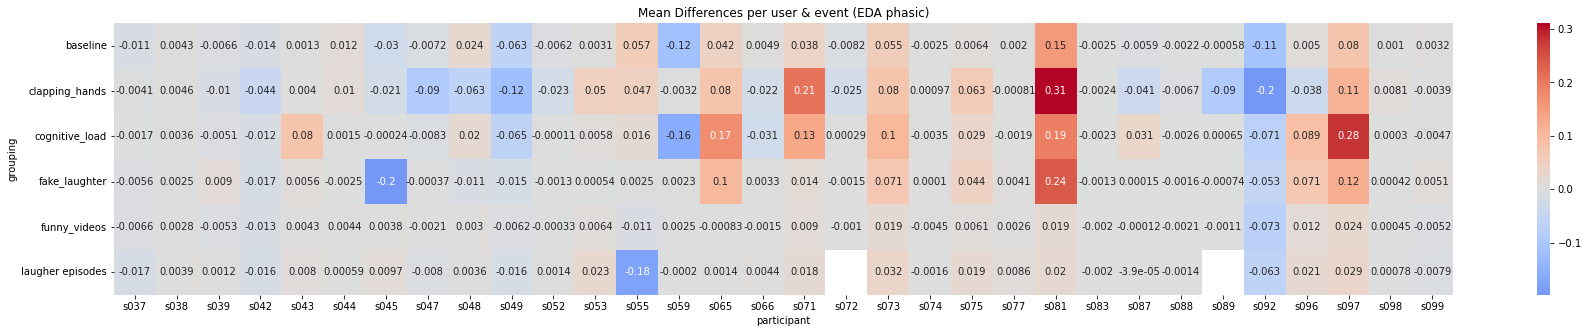

In [ ]:
from numpy import mean, asarray
from pandas import Series


mean_differences = different_groupings_eda_data_w_laugh.groupby(axis=0, level=[0, 1]).apply(
    calculate_mean_difference
)

df_to_save = mean_differences.groupby(level=0, group_keys=False).apply(change_orientation)

figure(figsize=(30, 5))
heatmap(df_to_save, 
        xticklabels=df_to_save.columns,
        center=0,
        cmap='coolwarm',
        yticklabels=df_to_save.index, annot=True)
title('Mean Differences per user & event (EDA phasic)')
savefig('../visualizations/meandiff_eda_phasic_eventXuser.pdf', bbox_inches='tight')
show()


In [26]:
from scipy.stats import pearsonr, kendalltau, spearmanr
print("Correlation Coefficients between Left-Right Pearson's ρ & Mean Differences")
val = pearsonr(even_correlations.iloc[:, 0], mean_differences)
print(f"Pearons: {val[0]} (p-value {val[1]})")
val = spearmanr(even_correlations.iloc[:, 0], mean_differences)
print(f"Spearman: {val[0]} (p-value {val[1]})")
val = kendalltau(even_correlations.iloc[:, 0], mean_differences)
print(f"Kendall: {val[0]} (p-value {val[1]})")

Correlation Coefficients between Left-Right Pearson's ρ & Mean Differences
Pearons: -0.01797225158713763 (p-value 0.8055928153225475)
Spearman: 0.02193704155677151 (p-value 0.7638552762288882)
Kendall: 0.011862990810359231 (p-value 0.8079743967913179)


In [27]:
calculate_mean_difference(eda_data)

0.002196711797933178

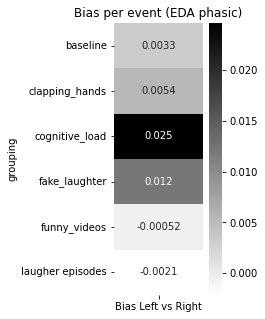

In [28]:
df_to_save = DataFrame(data=different_groupings_eda_data_w_laugh.groupby(axis=0, level=0).apply(
    calculate_mean_difference
), columns=['Bias Left vs Right'])
# df_to_save.columns = df_to_save.columns.droplevel(level=1)

figure(figsize=(2, 5))
heatmap(df_to_save, 
        xticklabels=df_to_save.columns,
        # vmax=1, vmin=-1, center=0,
        cmap='binary',
        yticklabels=df_to_save.index, 
        annot=True)
title('Bias per event (EDA phasic)')
savefig("../visualizations/event_bias_eda_phasic.pdf", bbox_inches='tight')
show()

From the differences plot, a few key takeways can be observed: overall, the general trend is that the left EDA has a higher activation that the right EDA. However, there are some users who present opposite behaviours. 

Making conclusions from this analysis is indeed not trivial, and should be treated carefully. Indeed, there could be some interesting findings, in line with what the literature has reported, but many wrongful statements could be made.

However, one of the major key problems, which is evident from the even-user bias plot above, is that the differences can be large for some event, e.g. cognitive load, but they are very dependent on the user. As such, I believe it is more interesting to show the mean of the *absolute differences* between the left and right side, across the events. 
This is done in order to figure out which event has a larger difference, since it could give some very interesting insight.

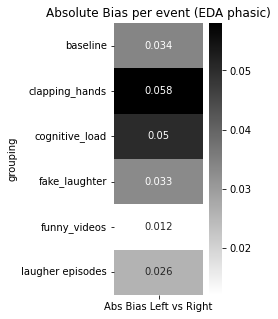

In [29]:
df_to_save = DataFrame(data=different_groupings_eda_data_w_laugh.groupby(axis=0, level=0).apply(
    calculate_mean_difference, use_abs=True
), columns=['Abs Bias Left vs Right'])
# df_to_save.columns = df_to_save.columns.droplevel(level=1)

figure(figsize=(2, 5))
heatmap(df_to_save, 
        xticklabels=df_to_save.columns,
        # vmax=1, vmin=-1, center=0,
        cmap='binary',
        yticklabels=df_to_save.index, 
        annot=True)
title('Absolute Bias per event (EDA phasic)')
savefig("../visualizations/event_absolute_bias_eda_phasic.pdf", bbox_inches='tight')
show()

From the absolute differences the story is slightly different: here, the clapping hands is the event with the largest difference: this can be indeed attributed to **motion artefacts**, which are indeed at the core of the "clapping hands" event. 

I have a small theory: the small the duration of the even, the larger the difference is. As such, let's see what happens if I multiply the values for the respective durations.

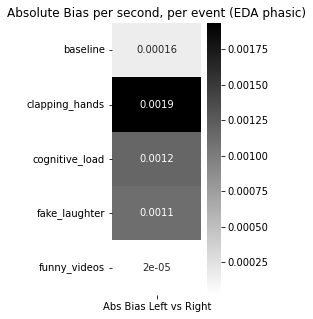

baseline          210.0
cognitive_load     43.0
fake_laughter      30.0
clapping_hands     30.0
funny_videos      592.0
Name: event durations, dtype: float64

In [ ]:
df_to_save = DataFrame(data=different_groupings_eda_data.groupby(axis=0, level=0).apply(
    calculate_mean_difference, use_abs=True
), columns=['Abs Bias Left vs Right'])
df_to_save = df_to_save.mul(1/events_durations, axis=0)
    
# df_to_save.columns = df_to_save.columns.droplevel(level=1)

figure(figsize=(2, 5))
heatmap(df_to_save, 
        xticklabels=df_to_save.columns,
        # vmax=1, vmin=-1, center=0,
        cmap='binary',
        yticklabels=df_to_save.index, 
        annot=True)
title('Absolute Bias per second, per event (EDA phasic)')
savefig("../visualizations/event_absolute_bias_eda_phasic_MULT_EVEN_CIRR.pdf", bbox_inches='tight')
show()
events_durations

From this plot, evaluating the absolute bias difference **per second** does not make a lot of sense. There are some clear changes when compared to the previous plot, but they are not enough to justify such a weird choice.

# PPG

In [29]:
# Load Data
all_data = read_parquet("../data.nosync/all_data_minmax_norm.parquet")
# NOTE: I consider only the datapoints where I have both the left and right signals
bvp_data = all_data.loc[:, IndexSlice[:, 'BVP_filt']].dropna(how='any')
bvp_data = bvp_data.groupby(level=0, axis=0, group_keys=False).apply(
    slice_user_over_experiment_time, experimento_info=experimento_info, slicing_col='experiment'
)
bvp_data.columns = bvp_data.columns.droplevel(1)

/Users/leonardoalchieri/Desktop/GIT/ContinuousLaugh/notebooks/../src/utils/__init__.py:177: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return user_data.loc[IndexSlice[:, start:end], :]
/Users/leonardoalchieri/Desktop/GIT/ContinuousLaugh/notebooks/../src/utils/__init__.py:177: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return user_data.loc[IndexSlice[:, start:end], :]
/Users/leonardoalchieri/Desktop/GIT/ContinuousLaugh/notebooks/../src/utils/__init__.py:177: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return user_data.loc[IndexSlice[:, start:end], :]
/Users/leonardoalchier

In [30]:
different_groupings_bvp_data: dict[str, DataFrame] = concat(
    [
        concat(
            [
                bvp_data.groupby(level=0, axis=0, group_keys=False).apply(
                    slice_user_over_experiment_time,
                    experimento_info=experimento_info,
                    slicing_col=session,
                )
                for session in session_group
            ]
        )
        for session_group in sessions_groupings.values()
    ],
    keys=[group_name for group_name in sessions_groupings.keys()],
    names=["grouping"],
)


/Users/leonardoalchieri/Desktop/GIT/ContinuousLaugh/notebooks/../src/utils/__init__.py:177: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return user_data.loc[IndexSlice[:, start:end], :]
/Users/leonardoalchieri/Desktop/GIT/ContinuousLaugh/notebooks/../src/utils/__init__.py:177: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return user_data.loc[IndexSlice[:, start:end], :]
/Users/leonardoalchieri/Desktop/GIT/ContinuousLaugh/notebooks/../src/utils/__init__.py:177: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return user_data.loc[IndexSlice[:, start:end], :]
/Users/leonardoalchier

In [31]:
different_groupings_bvp_data_w_laugh: dict[str, DataFrame] = concat(
    [
        concat(
            [
                bvp_data.groupby(level=0, axis=0, group_keys=False).apply(
                    slice_user_over_experiment_time,
                    experimento_info=experimento_info_w_laugh,
                    slicing_col=session,
                )
                for session in session_group
            ]
        )
        for session_group in sessions_groupings_w_laugh.values()
    ],
    keys=[group_name for group_name in sessions_groupings_w_laugh.keys()],
    names=["grouping"],
)


/Users/leonardoalchieri/Desktop/GIT/ContinuousLaugh/notebooks/../src/utils/__init__.py:177: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return user_data.loc[IndexSlice[:, start:end], :]
/Users/leonardoalchieri/Desktop/GIT/ContinuousLaugh/notebooks/../src/utils/__init__.py:177: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return user_data.loc[IndexSlice[:, start:end], :]
/Users/leonardoalchieri/Desktop/GIT/ContinuousLaugh/notebooks/../src/utils/__init__.py:177: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return user_data.loc[IndexSlice[:, start:end], :]
/Users/leonardoalchier

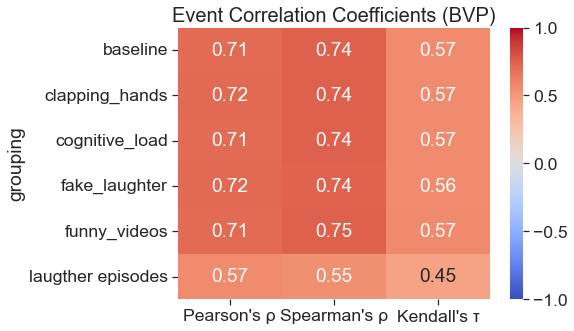

In [34]:
even_correlations = different_groupings_bvp_data_w_laugh.groupby(axis=0, level=0).apply(
    calculate_correlation_coefficients
)

df_to_save = even_correlations.loc[:, IndexSlice[:,'value']]
df_to_save.columns = df_to_save.columns.droplevel(level=1)

figure(figsize=(7, 5))
ax = heatmap(df_to_save, 
        xticklabels=df_to_save.columns,
        vmax=1, vmin=-1, center=0,
        cmap='coolwarm',
        yticklabels=df_to_save.index, annot=True)
ax.tick_params(left=True, bottom=True)
title(
    "Event Correlation Coefficients (BVP)", fontsize=20
)

set(font_scale=1.6)
savefig("../visualizations/event_correlation_bvp.pdf",  bbox_inches='tight')
show()

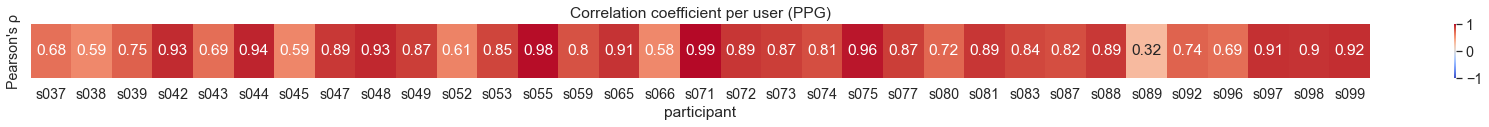

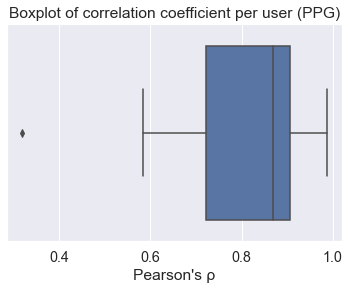

In [60]:
even_correlations = different_groupings_bvp_data.groupby(axis=0, level=1).apply(
    calculate_correlation_coefficients
)

df_to_save = even_correlations.loc[:, IndexSlice[:,'value']]
df_to_save.columns = df_to_save.columns.droplevel(level=1)
df_to_save = df_to_save.T
df_to_save = df_to_save.iloc[[0],:]
figure(figsize=(30, 1))
heatmap(df_to_save, 
        xticklabels=df_to_save.columns,
        vmax=1, vmin=-1, center=0,
        cmap='coolwarm',
        yticklabels=df_to_save.index, annot=True)
title('Correlation coefficient per user (PPG)')
savefig("../visualizations/user_correlation_pgg.pdf", bbox_inches='tight')
show()
from seaborn import boxplot


boxplot(x = df_to_save.iloc[0,:])
title('Boxplot of correlation coefficient per user (PPG)')
savefig("../visualizations/user_boxplot_pgg.pdf", bbox_inches='tight')
show()

As expected, the BVP data is consistent among all of the events: this is in line with the reported literature, which states that there is not tangibile difference between wearing a PPG device on the left or right side of the body.

/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_13371/2950578558.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_to_save = df_to_save.iloc[:,0].groupby(level=0, group_keys=False).apply(change_orientation)


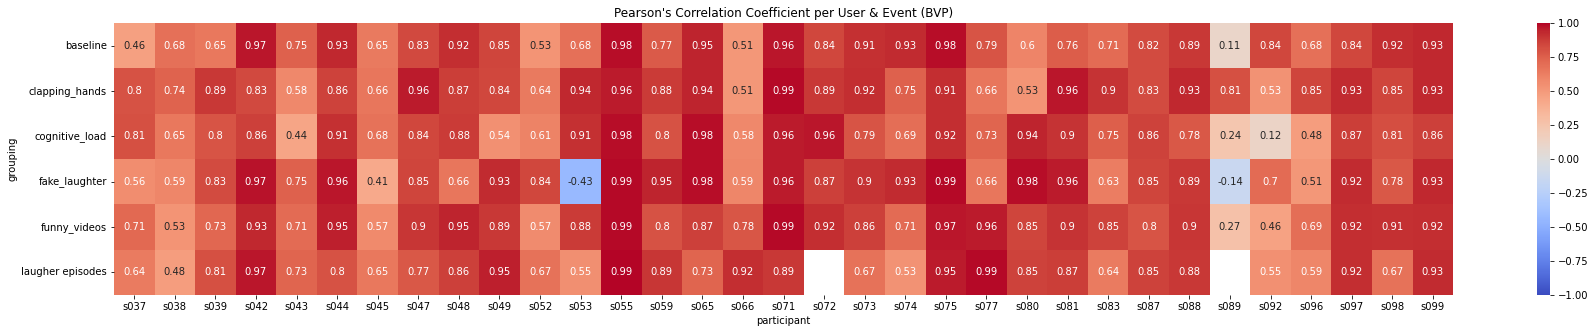

In [34]:
even_correlations = different_groupings_bvp_data.groupby(axis=0, level=[0,1]).apply(
    calculate_correlation_coefficients
)
df_to_save = even_correlations.loc[:, IndexSlice[:,'value']]

df_to_save = df_to_save.iloc[:,0].groupby(level=0, group_keys=False).apply(change_orientation)

figure(figsize=(30, 5))
heatmap(df_to_save, 
        xticklabels=df_to_save.columns,
        vmax=1, vmin=-1, center=0,
        cmap='coolwarm',
        yticklabels=df_to_save.index, annot=True)
savefig('../visualizations/event_correlation_bvp_evenxuser.pdf')
title("Pearson's Correlation Coefficient per User & Event (BVP)")
show()

Again, the results are very consisten. There are some values with problems, but can most likely attributed to some motion artefact.

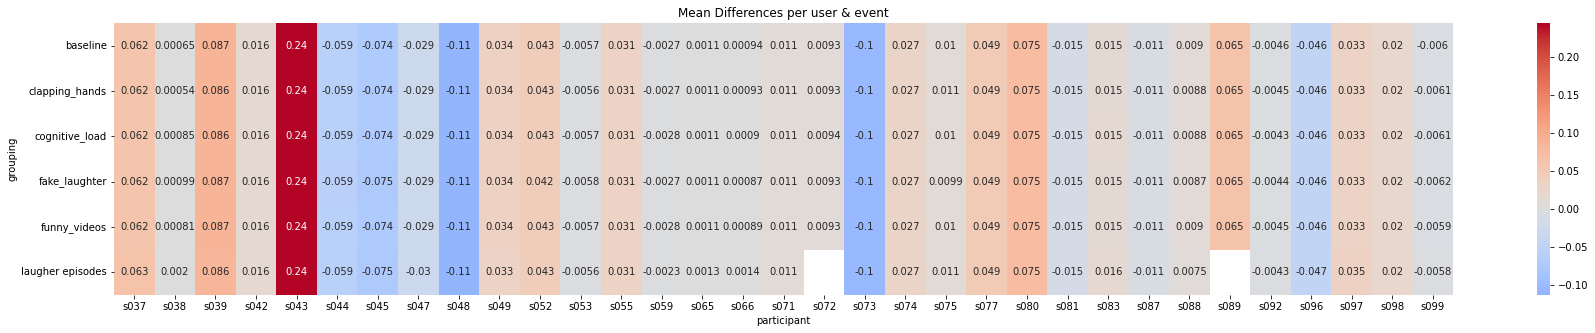

In [35]:
from numpy import mean, asarray
from pandas import Series


mean_differences = different_groupings_bvp_data.groupby(axis=0, level=[0, 1]).apply(
    calculate_mean_difference
)

df_to_save = mean_differences.groupby(level=0, group_keys=False).apply(change_orientation)

figure(figsize=(30, 5))
heatmap(df_to_save, 
        xticklabels=df_to_save.columns,
        center=0,
        cmap='coolwarm',
        yticklabels=df_to_save.index, annot=True)
savefig('../visualizations/meandiff_bvp_eventXuser.pdf')
title('Mean Differences per user & event')
show()


There is some bias, i.e. positive or negative mean differences, between the left and right side of the body. However, they are **very** consistent across events, which is to suggest that no bias is introduced when a difference neurological activation is present, as opposed to the EDA signal, which does indeed show some remarkable elements.

# ACC

This is a simple ACC analysis. The idea is to figure out if the users that present the weirdest results are also those with the highest average ACC data. However, it could be tricky to try to remove such elements, since it would be necessary of a justification.

In [88]:
# NOTE: I consider only the datapoints where I have both the left and right signals
acc_data = all_data.loc[:, IndexSlice[:, 'ACC_filt']].dropna(how='any')
acc_data = acc_data.groupby(level=0, axis=0, group_keys=False).apply(
    slice_user_over_experiment_time, experimento_info=experimento_info, slicing_col='experiment'
)
acc_data.columns = acc_data.columns.droplevel(1)

/Users/leonardoalchieri/Desktop/GIT/ContinuousLaugh/notebooks/../src/utils/__init__.py:177: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return user_data.loc[IndexSlice[:, start:end], :]
/Users/leonardoalchieri/Desktop/GIT/ContinuousLaugh/notebooks/../src/utils/__init__.py:177: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return user_data.loc[IndexSlice[:, start:end], :]
/Users/leonardoalchieri/Desktop/GIT/ContinuousLaugh/notebooks/../src/utils/__init__.py:177: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return user_data.loc[IndexSlice[:, start:end], :]
/Users/leonardoalchier

In [91]:
different_groupings_acc_data: dict[str, DataFrame] = concat(
    [
        concat(
            [
                acc_data.groupby(level=0, axis=0, group_keys=False).apply(
                    slice_user_over_experiment_time,
                    experimento_info=experimento_info,
                    slicing_col=session,
                )
                for session in session_group
            ]
        )
        for session_group in sessions_groupings.values()
    ],
    keys=[group_name for group_name in sessions_groupings.keys()],
    names=["grouping"],
)


/Users/leonardoalchieri/Desktop/GIT/ContinuousLaugh/notebooks/../src/utils/__init__.py:177: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return user_data.loc[IndexSlice[:, start:end], :]
/Users/leonardoalchieri/Desktop/GIT/ContinuousLaugh/notebooks/../src/utils/__init__.py:177: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return user_data.loc[IndexSlice[:, start:end], :]
/Users/leonardoalchieri/Desktop/GIT/ContinuousLaugh/notebooks/../src/utils/__init__.py:177: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return user_data.loc[IndexSlice[:, start:end], :]
/Users/leonardoalchier

/Users/leonardoalchieri/miniconda3/envs/laugh/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


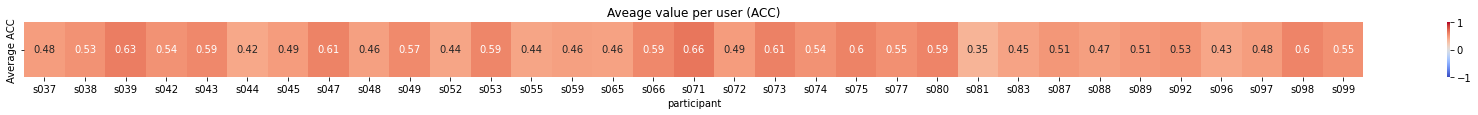

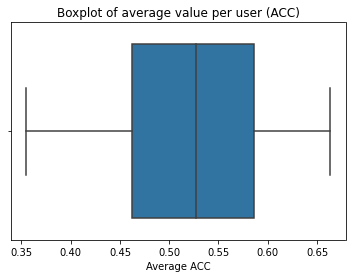

In [107]:
user_avg: DataFrame = different_groupings_bvp_data.groupby(axis=0, level=1).apply(mean)

df_to_save: Series = user_avg.mean(axis=1)
df_to_save = DataFrame(df_to_save, columns=['Average ACC']).T
figure(figsize=(30, 1))
heatmap(
    df_to_save,
    xticklabels=df_to_save.columns,
    vmax=1,
    vmin=-1,
    center=0,
    cmap="coolwarm",
    yticklabels=df_to_save.index,
    annot=True,
)
title("Aveage value per user (ACC)")
savefig("../visualizations/user_avg_acc.pdf", bbox_inches="tight")
show()
from seaborn import boxplot


boxplot(x=df_to_save.iloc[0, :])
title("Boxplot of average value per user (ACC)")
savefig("../visualizations/user_avg_boxplot_acc.pdf", bbox_inches="tight")
show()


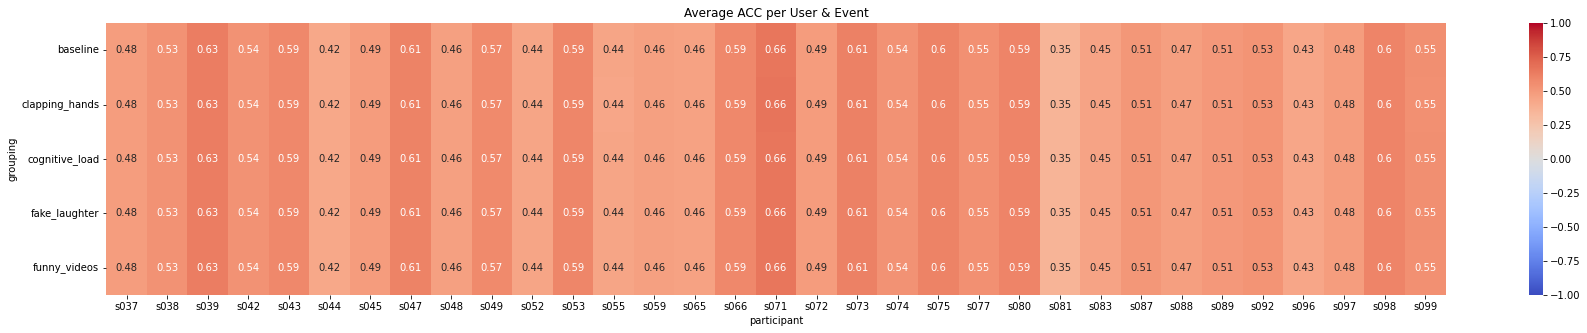

In [121]:
user_avg: DataFrame = (
    different_groupings_bvp_data.groupby(axis=0, level=[0, 1]).apply(mean)
)

df_to_save: Series = user_avg.mean(axis=1)
df_to_save = df_to_save.iloc[:].groupby(level=0, group_keys=False).apply(change_orientation)

figure(figsize=(30, 5))
heatmap(
    df_to_save,
    xticklabels=df_to_save.columns,
    vmax=1,
    vmin=-1,
    center=0,
    cmap="coolwarm",
    yticklabels=df_to_save.index,
    annot=True,
)
title("Average ACC per User & Event")
savefig("../visualizations/avg_acc_userXevent.pdf")
show()


From this results, it does not appear that there is a correlation "high movers" and "weird results" in the previous analysis. As such, no further investigation shall be performed.